In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

Bay area bike share data on Google BigQuery: 
https://bigquery.cloud.google.com/table/bigquery-public-data:san_francisco.bikeshare_trips

In [3]:
# Access for Google BigQuery
from pandas.io import gbq
project_id = 'fluted-galaxy-165204'

In [4]:
import scipy.stats as stats
import sklearn

In [5]:
# Retrieve trip data
trips_query="""
SELECT *
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
"""

df_trips = gbq.read_gbq(trips_query, project_id=project_id, dialect='standard')

Requesting query... ok.
Query running...
Query done.
Processed: 119.9 Mb

Retrieving results...
  Got page: 1; 3.0% done. Elapsed 13.73 s.
  Got page: 2; 6.0% done. Elapsed 20.23 s.
  Got page: 3; 10.0% done. Elapsed 28.42 s.
  Got page: 4; 13.0% done. Elapsed 36.35 s.
  Got page: 5; 16.0% done. Elapsed 43.04 s.
  Got page: 6; 19.0% done. Elapsed 48.98 s.
  Got page: 7; 23.0% done. Elapsed 56.41 s.
  Got page: 8; 26.0% done. Elapsed 63.47 s.
  Got page: 9; 29.0% done. Elapsed 73.67 s.
  Got page: 10; 32.0% done. Elapsed 79.65 s.
  Got page: 11; 36.0% done. Elapsed 86.61 s.
  Got page: 12; 39.0% done. Elapsed 96.73 s.
  Got page: 13; 42.0% done. Elapsed 103.88 s.
  Got page: 14; 45.0% done. Elapsed 111.18 s.
  Got page: 15; 49.0% done. Elapsed 121.45 s.
  Got page: 16; 52.0% done. Elapsed 127.6 s.
  Got page: 17; 55.0% done. Elapsed 135.41 s.
  Got page: 18; 58.0% done. Elapsed 142.54 s.
  Got page: 19; 61.0% done. Elapsed 157.74 s.
  Got page: 20; 65.0% done. Elapsed 164.82 s.
  Got pa

In [17]:
df_trips = df_trips.sort_values('trip_id')
df_trips.head()

,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type
977394,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,94114,Subscriber
763333,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,94703,Subscriber
807402,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,94115,Subscriber
919552,4075,1117,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,316,94122,Subscriber
437635,4076,1118,2013-08-29 09:25:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,322,94597,Subscriber


## Predicting bike usage 

#### 1. Daily bike usage prediction
We start by predicting the daily bike usage. We would like to define the daily usage as the number of trips that "occurs" in a day, one intuitive way is to count the number of trips that start in a day. However, one potential problem is that some trips may span across days (either a very long time period or a trip occurring around midnight).

In [24]:
print "Number of cross-day trips: ", sum(df_trips.start_date.dt.date != df_trips.end_date.dt.date)
print "Number of total trips: ", len(df_trips)

Number of cross-day trips:  2583
Number of total trips:  983648


We could see that less than 0.3% of trips are cross-day trips. Let's use the start date to define the daily bike usage for now.

In [92]:
df_trips_day = df_trips[['duration_sec', 'start_date']]
df_trips_day['rides'] = 1
df_daily = df_trips_day.groupby(df_trips_day.start_date.dt.date).sum()

/Users/changhengwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [93]:
weather = pd.DataFrame.from_csv('data/201402_babs_open_data/201402_weather_data.csv', index_col=None)

In [94]:
df_daily = df_daily.reset_index()
df_daily.head()

,start_date,duration_sec,rides
0,2013-08-29,1167850,748
1,2013-08-30,1930037,714
2,2013-08-31,2342473,640
3,2013-09-01,2404578,706
4,2013-09-02,1543638,661


In [120]:
df_daily['day'] = pd.to_datetime(df_daily.start_date).dt.weekday
df_daily['week'] = pd.to_datetime(df_daily.start_date).dt.week
df_daily['month'] = pd.to_datetime(df_daily.start_date).dt.month
df_daily.head()

,start_date,duration_sec,rides,day,week,month
0,2013-08-29,1167850,748,3,35,8
1,2013-08-30,1930037,714,4,35,8
2,2013-08-31,2342473,640,5,35,8
3,2013-09-01,2404578,706,6,35,9
4,2013-09-02,1543638,661,0,36,9


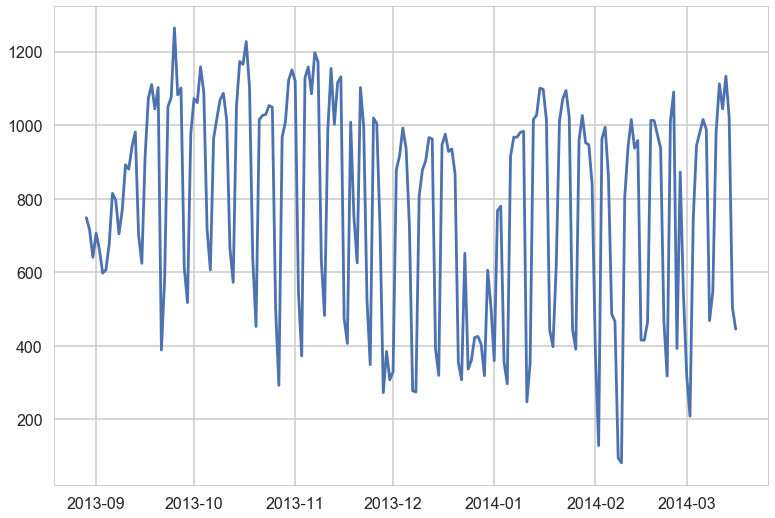

In [121]:
plt.plot(df_daily.start_date[:200], df_daily.rides[:200])

In [122]:
len(df_daily)

1099

In [164]:
# Split train and test data
X_train = df_daily[['day', 'week', 'month']][50:-50]
X_test = df_daily[['day', 'week', 'month']][-50:]
Y_train = df_daily['rides'][50:-50]
Y_test = df_daily['rides'][-50:]
date_test = df_daily['start_date'][-50:]

#### Linear regression with scikit learn

In [165]:
# Fit linear regression with scikit learn
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [166]:
predicted = lm.predict(X_test)

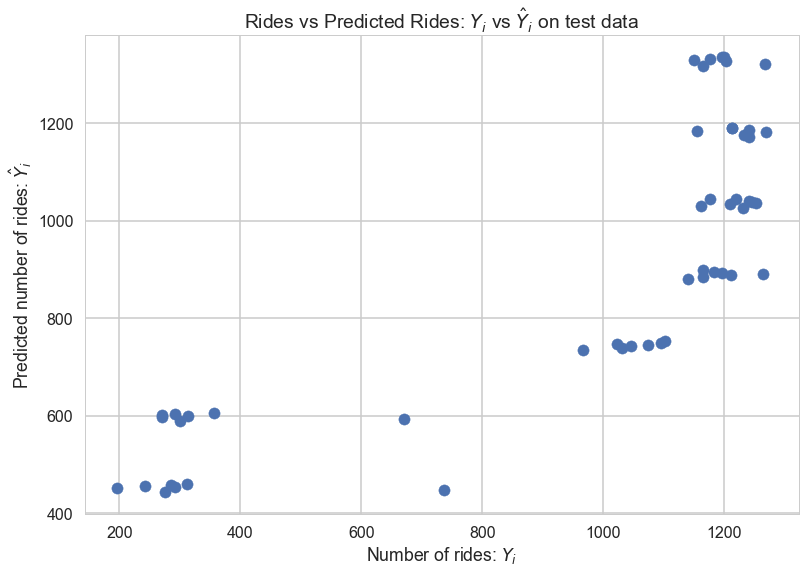

In [167]:
plt.scatter(Y_test, predicted)
plt.xlabel("Number of rides: $Y_i$")
plt.ylabel("Predicted number of rides: $\hat{Y}_i$")
plt.title("Rides vs Predicted Rides: $Y_i$ vs $\hat{Y}_i$ on test data")

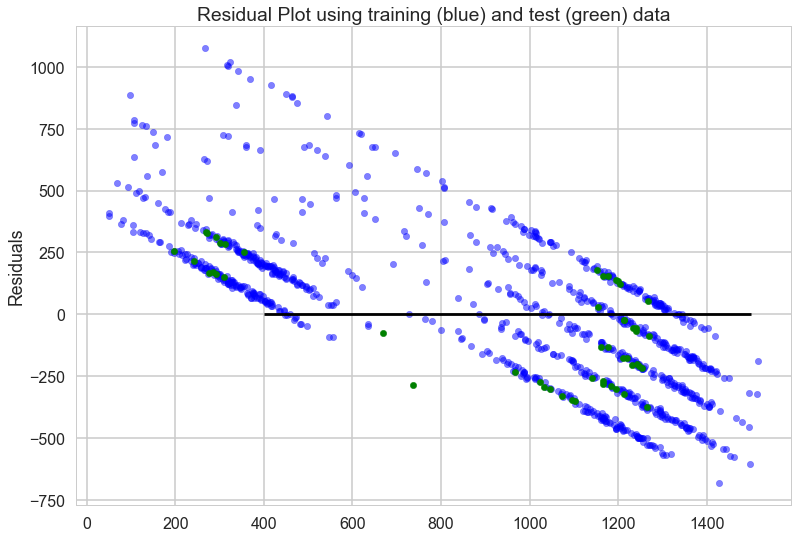

In [168]:
plt.scatter(Y_train, lm.predict(X_train) - Y_train, c='b', s=40, alpha=0.5)
plt.scatter(Y_test, lm.predict(X_test) - Y_test, c='g', s=40)
plt.hlines(y = 0, xmin=400, xmax = 1500)
plt.title('Residual Plot using training (blue) and test (green) data')
plt.ylabel('Residuals')

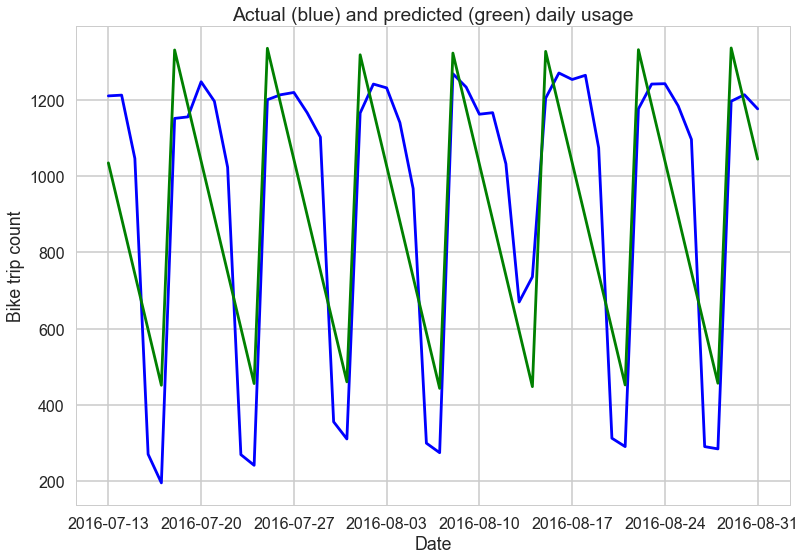

In [181]:
plt.plot(date_test, Y_test, c='b')
plt.plot(date_test, predicted, c='g')
plt.xlabel('Date')
plt.ylabel('Bike trip count')
plt.title('Actual (blue) and predicted (green) daily usage')

#### Support vector regression with scikit learn

In [171]:
from sklearn.svm import SVR

In [176]:
svr = SVR(C=1e4, gamma=0.1)
svr.fit(X_train, Y_train)

SVR(C=10000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

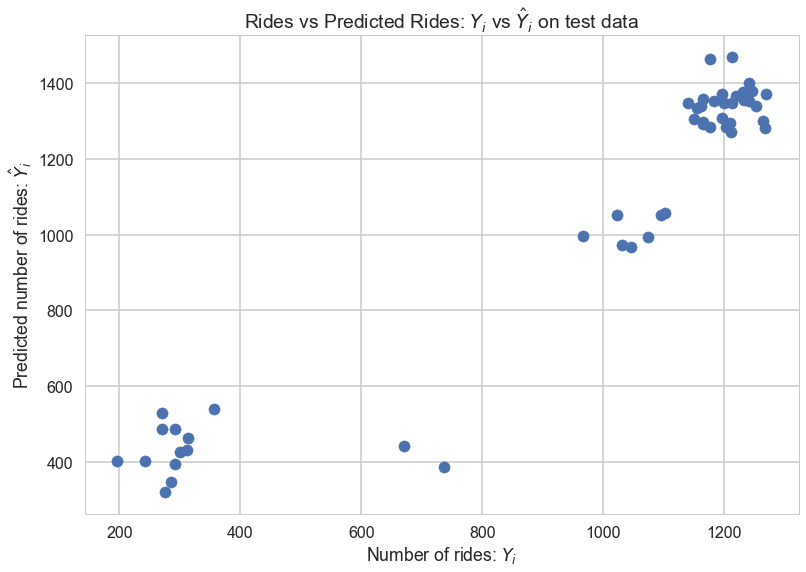

In [177]:
predicted_svr = svr.predict(X_test)
plt.scatter(Y_test, predicted_svr)
plt.xlabel("Number of rides: $Y_i$")
plt.ylabel("Predicted number of rides: $\hat{Y}_i$")
plt.title("Rides vs Predicted Rides: $Y_i$ vs $\hat{Y}_i$ on test data")

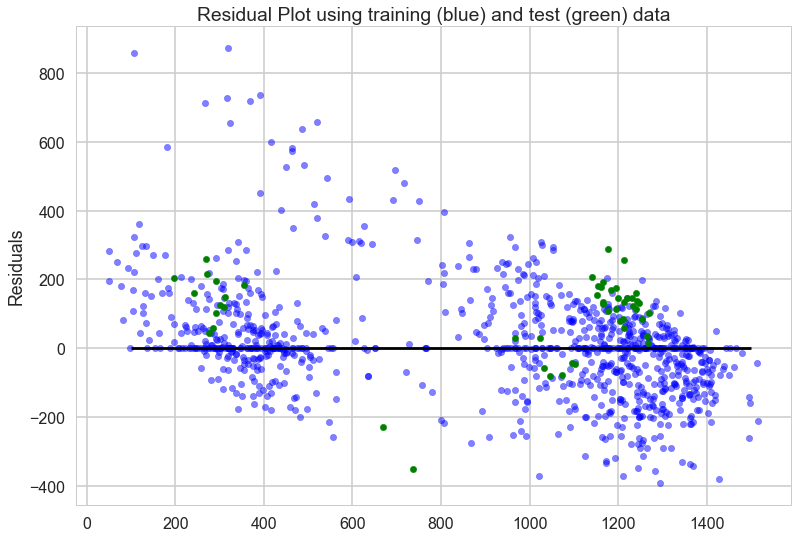

In [178]:
plt.scatter(Y_train, (svr.predict(X_train) - Y_train), c='b', s=40, alpha=0.5)
plt.scatter(Y_test, (svr.predict(X_test) - Y_test), c='g', s=40)
plt.hlines(y = 0, xmin=100, xmax = 1500)
plt.title('Residual Plot using training (blue) and test (green) data')
plt.ylabel('Residuals')

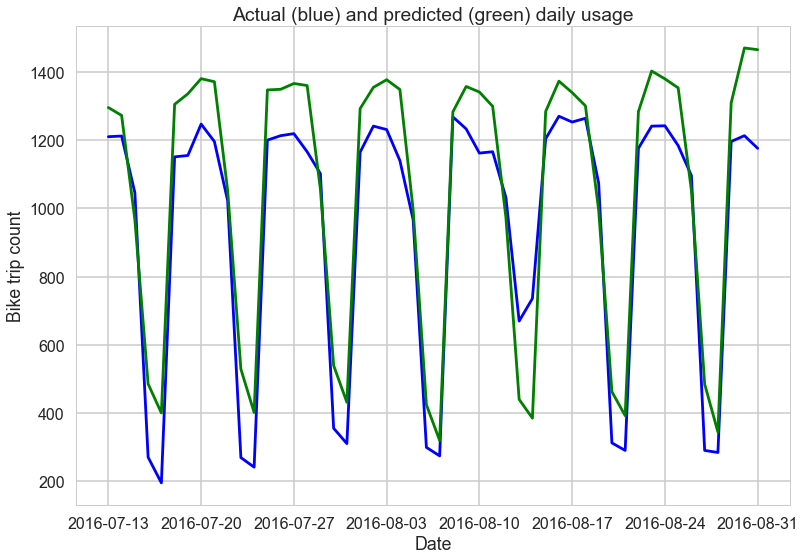

In [179]:
plt.plot(date_test, Y_test, c='b')
plt.plot(date_test, predicted_svr, c='g')
plt.xlabel('Date')
plt.ylabel('Bike trip count')
plt.title('Actual (blue) and predicted (green) daily usage')

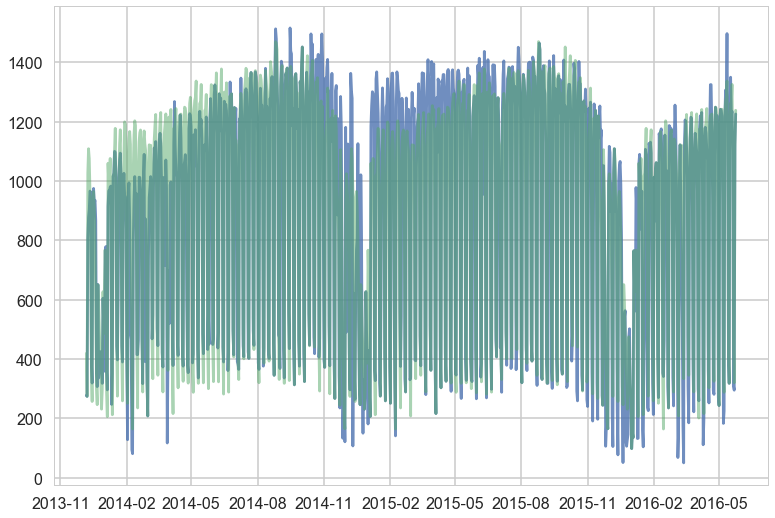

In [222]:
date_range = range(100, 1000)
plt.plot(df_daily.start_date[date_range], df_daily.rides[date_range], alpha=0.8)
plt.plot(df_daily.start_date[date_range], svr.predict(df_daily[['day', 'week', 'month']].loc[date_range, :]), alpha=0.5)